In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import json
from PIL import Image, ImageDraw
import cv2
import keras

Using TensorFlow backend.


In [13]:
input_path = '/home/aziz/Documents/Cars_Proj/input/data/'

In [14]:
train = sorted(glob(os.path.join(input_path, 'train/*.jpeg')))
val = sorted(glob(os.path.join(input_path, 'val/*.jpeg')))

In [15]:
len(train), len(val)

(1125, 375)

In [16]:
json_file = open(os.path.join(input_path, 'train.json'))
train_masks_json = json.load(json_file)

json_file = open(os.path.join(input_path, 'val.json'))
val_masks_json = json.load(json_file)

In [6]:
# import cv2
# from albumentations import (
#     Compose, HorizontalFlip, CLAHE, HueSaturationValue,
#     RandomBrightness, RandomContrast, RandomGamma,OneOf,
#     ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
#     RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
#     IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
# )
# h = w = 512

# AUGMENTATIONS_TRAIN = Compose([
#     HorizontalFlip(p=0.5),
#     OneOf([
#         RandomContrast(),
#         RandomGamma(),
#         RandomBrightness(),
#          ], p=0.3),
#     OneOf([
#         ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#         GridDistortion(),
#         OpticalDistortion(distort_limit=2, shift_limit=0.5),
#         ], p=0.3),
#     RandomSizedCrop(min_max_height=(128, 256), height=h, width=w,p=0.5),
#     ToFloat(max_value=1)
# ],p=1)


# AUGMENTATIONS_TEST = Compose([
#     ToFloat(max_value=1)
# ],p=1)

In [17]:
from keras.models import load_model
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [18]:
model = load_model('/home/aziz/Documents/Cars_Proj/models/unet_1.h5')

W0816 10:41:03.382148 140000840087296 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/cars_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 10:41:03.660813 140000840087296 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/cars_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0816 10:41:03.677854 140000840087296 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/cars_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 10:41:03.678409 140000840087296 deprecation_wrapper.py:119] From /home/aziz/anaconda3/envs/cars_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_w

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [64]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2
from skimage.filters import threshold_local

In [45]:
sys.path.append('/home/aziz/Documents/Cars_Proj')

In [117]:
import src.dataPrep as DP
import src.imageFuncs as imageFuncs

from importlib import reload
reload(DP)
reload(imageFuncs)


<module 'src.imageFuncs' from '/home/aziz/Documents/Cars_Proj/src/imageFuncs.py'>

In [126]:
img = Image.open('/home/aziz/Documents/Cars_Proj/input/data/val/250031934orig.jpeg')
img = img.resize((512, 512))
img = np.asarray(img)
img = img.reshape((1, 512, 512, 3))

In [127]:
res = model.predict(img)
res = res.reshape(512, 512)
res = np.where(res > 0.5, 1, 0)
img = img.reshape(512, 512, 3)
screenCnt = imageFuncs.get_countour(res)

In [129]:
img_cnt = cv2.drawContours(img.copy(), [screenCnt], -1, (0, 255, 0), 2)

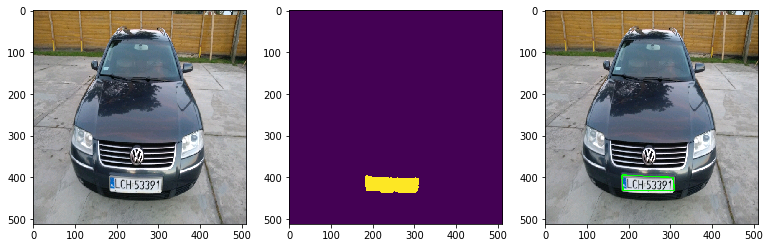

In [130]:
fig, ax = plt.subplots(1, 3, figsize=(13,13))

ax[0].imshow(img)
ax[1].imshow(res)
ax[2].imshow(img_cnt)
plt.show()

In [156]:
warped = imageFuncs.four_point_transform(img, screenCnt.reshape(4, 2))
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

# if warped.mean() > 255/2:
#     T = 130
#     warped = (warped < T).astype("uint8") * 255
# else:
#     T = 80
#     warped = (warped > T).astype("uint8") * 255

# T = threshold_local(warped, 15, offset = 15, method = "gaussian")
# warped = (warped > T).astype("uint8") * 255

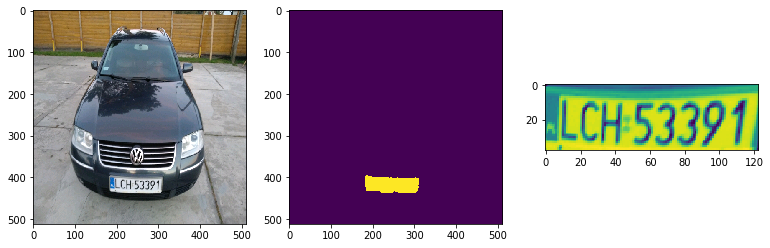

In [157]:
fig, ax = plt.subplots(1, 3, figsize=(13,13))

ax[0].imshow(img)
ax[1].imshow(res)
ax[2].imshow(warped)
plt.show()

In [154]:
import pytesseract

In [158]:
pytesseract.image_to_string(warped, lang='eng', )

'IVLCH 533911'

In [143]:
warped.mean(), warped.min(), warped.max()

(173.7732135216089, 28, 236)

In [138]:
255/2

127.5